# Image Transforms

* Haar transform
* Wavelet compression and reconstruction using Haar

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [23]:
""" For the wavelet transforms, we will need to convolute and upsample or downsample the signals
Upsampling is done by inserting a row/column of zeros into the matrix followed by a filtering operation
Downsamplig is done by filtering followed by removing a row/column 
"""

def upsample(X,axis=0):
    # The upsample function adds 0 inbetween every other row/column
    X = np.insert(X,np.arange(1,X.shape[axis]-1),0, axis)
    return X

def downsample(X,axis=0):
    # The downsample function takes every other entry along the axis
    if(axis==0):
        X = X[0::2,:]
    else:
        X = X[:,0::2]
    return X

def conv2down(X,h1,h2):
    # This function convolves and downsamples at the same time
    X = cv2.filter2D(X,-1,h1)
    X = downsample(X,axis=0)  # note we filter along one axis and down sample that axis
    X = cv2.filter2D(X,-1,h2.transpose())  # then we filter with the transpose and do the other axis
    return downsample(X,axis=1)

def conv2up(X,h1,h2):
    # This function convolves and upsamples at the same time
    X = upsample(X,axis=1)
    X = cv2.filter2D(X,-1,h1.transpose())  # Fill with zeros along an axis and then filter that axis
    X = upsample(X,axis=0)  # Do the other axis
    return cv2.filter2D(X,-1,h2)
    

In [24]:
lena_img = cv2.imread(os.path.relpath('../../Data/Lena.jpeg'), cv2.IMREAD_GRAYSCALE)
#  I was having some issues with rounding/clipping because its an 8 bit np.array
lena_img=lena_img.astype(np.double)

## Let's play around with the Haar transform

For N = 2
* Psi   = 1/sqrt(2)*[1 1]   - This is an integrator, so its a low-pass filter
* Theta = 1/sqrt(2)*[1 -1]  - This is a differentiator, so high-pass

In [25]:
# Haar Encoding Low pass
haar_EL = 1.0/math.sqrt(2.0)*np.array(([1.0],[1.0]))

# Haar Encoding High pass
haar_EH = 1.0/math.sqrt(2.0)*np.array(([-1.0],[1.0]))
     
# Wavelet trasform and downsampling
img_LL = conv2down(lena_img,haar_EL,haar_EL)
img_LH = conv2down(lena_img,haar_EL,haar_EH)
img_HL = conv2down(lena_img,haar_EH,haar_EL)
img_HH = conv2down(lena_img,haar_EH,haar_EH)



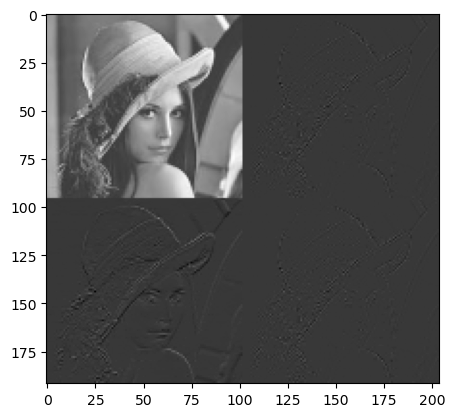

In [26]:
plt.imshow(np.vstack((np.hstack((img_LL,img_LH)),np.hstack((img_HL,img_HH)))),cmap='gray')

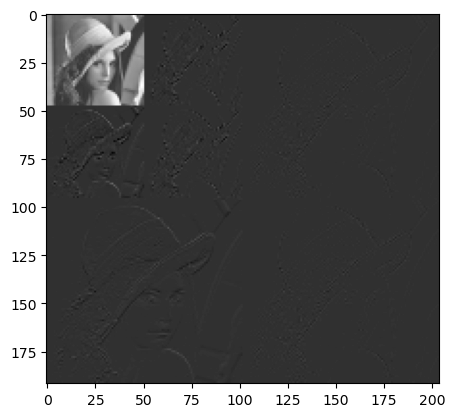

In [27]:
# We can transform anouther round

# Second stage of wavelets
img_LLLL = conv2down(img_LL,haar_EL,haar_EL)
img_LLLH = conv2down(img_LL,haar_EH,haar_EH)
img_LLHL = conv2down(img_LL,haar_EH,haar_EL)
img_LLHH = conv2down(img_LL,haar_EH,haar_EH)

# total transform of img_LL
img_LLx = np.vstack((np.hstack((img_LLLL,img_LLLH)),np.hstack((img_LLHL,img_LLHH))))

plt.imshow(np.vstack((np.hstack((img_LLx,img_LH)),np.hstack((img_HL,img_HH)))),cmap='gray')


## Reconstructing the image

Text(0.5, 1.0, 'Reconstructed 75% Compression')

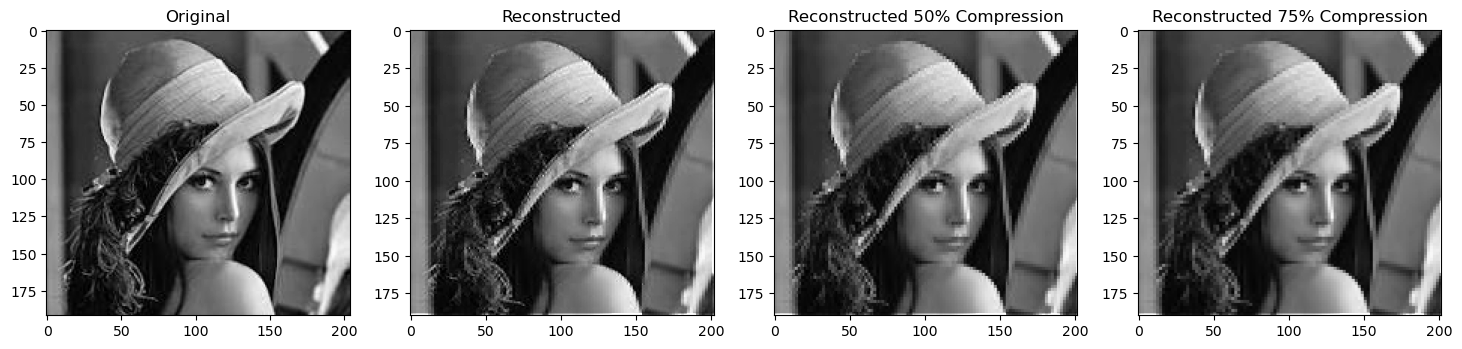

In [28]:
# Haar Reconstruction Low pass
haar_RL = 1.0/math.sqrt(2.0)*np.array(([1.0],[1.0]))    # note this has to be a <2x1> matrix (not an array) for the transponse operation

# Haar Reconstruction High pass
haar_RH = 1.0/math.sqrt(2.0)*np.array(([1.0],[-1.0]))

# Do the opposite of what we did to compress the image
img1=conv2up(img_LL,haar_RL,haar_RL)
img2=conv2up(img_LH,haar_RH,haar_RL)  # Note since img_LH was L first then H, we need to do H first then L to recover
img3=conv2up(img_HL,haar_RL,haar_RH)
img4=conv2up(img_HH,haar_RH,haar_RH)

# Show the images
plt.figure(figsize=[18, 5])

plt.subplot(141);plt.imshow(lena_img,cmap='gray',vmin=0,vmax=255);  plt.title("Original")
plt.subplot(142);plt.imshow(img1+img2+img3+img4,cmap='gray',vmin=0,vmax=255);plt.title("Reconstructed")
plt.subplot(143);plt.imshow(img1+img2,cmap='gray',vmin=0,vmax=255);  plt.title("Reconstructed 50% Compression")
plt.subplot(144);plt.imshow(img1,cmap='gray',vmin=0,vmax=255);  plt.title("Reconstructed 75% Compression")

